In [2]:
import pandas as pd
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
import collections
import networkx as nx

In [3]:
random.seed(30)

In [4]:
df= pd.read_pickle("../Data/movielen/movielen_1M_ctr_time.pickle")

In [5]:
df.columns=["userid", "itemid", "rating", "timestamp"]
sorted_df = df[["userid", "itemid", "timestamp"]]

In [6]:
print("number of actions", len(sorted_df))

number of actions 494637


In [7]:
sorted_df.itemid.unique().min()

1

In [107]:
G = nx.Graph()
G.add_edge('a', 'b', weight=7, attr=[[1], [2], [3], [4]])
G.add_edge('a', 'c', weight=7, attr=[[5], [2], [7], [8]])

In [113]:
G['a']['c']['attr'][2]

[7]

In [100]:
G['a']['b']['weight'] = 6

In [17]:
G = nx.Graph()
G.add_edge(1, 2)
G.add_edge(1, 3)

In [20]:
G.nodes()

NodeView((1, 2, 3))

In [50]:
list(G.neighbors(1)), G.has_node(1)

([2, 3], True)

In [12]:
class _seq_corpus: 
    def __init__(self):
        self.m_seq_list = []
        self.m_seq_num = 0
        
    def f_add_seq(self, seq_obj):
        self.m_seq_list.append(seq_obj)
        self.m_seq_num += 1
        
    def f_get_seq_num(self):
        return self.m_seq_num
        
        
class _seq:
    def __init__(self):
        self.m_seq_id = -1
        self.m_target = -1
        self.m_item_list = []
        self.m_time_list = []
        self.m_target_pos = -1
        
        self.m_neigh_diff_item_list = []
        self.m_neigh_diff_time_list = []
        
        self.m_neigh_common_item_list = [] ###[[]]
        self.m_neigh_common_time_list = [] ###[[]]
        
    def f_set_self_list(self, item_list, time_list):
        self.m_item_list = item_list
        self.m_time_list = time_list
        
    def f_set_friend_diff(self, item_list, time_list):
        self.m_neigh_diff_item_list = item_list
        self.m_neigh_diff_time_list = time_list
        
    def f_set_friend_common(self, neigh_common_item_list, neigh_common_time_list):
        self.m_neigh_common_item_list = neigh_common_item_list
        self.m_neigh_common_time_list = neigh_common_time_list
    
    def f_set_target(self, target):
        self.m_target = target

In [50]:
sequence_len_max_item = 200
max_friend_num = 1e2
class _user:
    def __init__(self, user_id, uid):
        self.m_user_id = user_id
        self.m_uid = uid
        self.m_debug_item_list = []
#         self.m_item_obj_list = collections.deque(maxlen=sequence_len_max_item)
#         self.m_item_id_list = collections.deque(maxlen=sequence_len_max_item)
#         self.m_time_list = collections.deque(maxlen=sequence_len_max_item)
        self.m_item_id_list = []
        self.m_time_list = []
        self.m_item_num = 0
        self.m_item_index_user = 0
        
    def f_add_item_time(self, itemid, time):
        self.m_item_id_list.append(itemid)
        self.m_time_list.append(time)
        self.m_item_num = len(self.m_item_id_list)
        self.m_item_index_user += 1
        
    def f_get_item_num(self):
        return self.m_item_num
    
    def f_get_item_id_list(self):
        return list(self.m_item_id_list)
    
    def f_get_time_list(self):
        return list(self.m_time_list)

In [31]:
# sequence_len_max_user = 1000
# class _item:
#     def __init__(self, item_id):
#         self.m_iid = item_id
#         self.m_user_id_list = collections.deque(maxlen=sequence_len_max_user)
#         self.m_user_num = 0
    
#     def f_add_user_id(self, user_id):
#         self.m_user_id_list.append(user_id)
#         self.m_user_num = len(self.m_user_id_list)
        
#     def f_get_user_id_list(self):
#         return list(self.m_user_id_list)

In [51]:
class _corpus:
    def __init__(self):
        ### raw user id to uid
        self.m_userid_uid_map = {}
        ### uid to raw user id
        self.m_uid_userid_map = {}
        
        self.m_iid_uidlist_map = {}
        
        self.m_uid_obj_map = {}
#         self.m_itemid_obj_map = {}
        self.m_user_num = 0
        self.m_user_user_common_item_map = {}
        self.m_user_user_common_time_map = {}
        self.m_user_user_diff_item_map = {}
        self.m_user_user_diff_time_map = {}
    
        self.m_user_graph = nx.Graph()
#         self.m_item_num = 0
        
    def f_add_user(self, uid, user_obj):
        if user_id in self.m_uid_obj_map:
            print('error user exist')
        else:
            self.m_uid_obj_map[uid] = user_obj
            self.m_user_num += 1
        
    def f_add_user2item(self, uid, iid):
        if iid not in self.m_iid_uidlist_map:
            self.m_iid_uidlist_map[iid] = []
        
        if uid in self.m_iid_uidlist_map[iid]:
            return
        
        self.m_iid_uidlist_map[iid].append(uid)
        
    def f_user_exist(self, uid):
        if uid in self.m_uid_obj_map:
            return True
        else:
            return False
#     def f_item_exist(self, item_id):
#         if item_id in self.m_itemid_obj_map:
#             return True
#         else:
#             return False
    
    def f_get_user(self, uid, user_id):
        if self.f_user_exist(uid):
            return self.m_uid_obj_map[uid]
        else:
            user_obj = _user(uid, user_id)
            self.f_add_user(uid, user_obj)
            return user_obj
    
    ### did not consider same user
    ### uid < vid 
    
    def f_add_node(self, uid, iid):
        if iid not in self.m_iid_uidlist_map:
            return
        
        if self.m_user_graph.has_node(uid):
            vid_list = corpus_obj.m_user_graph.neighbors(uid)
            for vid in vid_list:
                corpus_obj.m_user_graph[uid][vid]['weight'] = 1.0
        
        if uid not in self.m_user_user_common_item_map:
            self.m_user_user_common_item_map[uid] = {}
            self.m_user_user_common_time_map[uid] = {}
            self.m_user_user_diff_item_map[uid] = {}
            self.m_user_user_diff_time_map[uid] = {}
        
        vid_list = self.m_iid_uidlist_map[iid]
        for vid in vid_list:
            self.m_user_graph.add_edge(uid, vid, weight=1, attr=[0, 0])
            
            if vid not in self.m_user_user_common_item_map[uid]:
                self.m_user_user_common_item_map[uid][vid] = []
                self.m_user_user_common_time_map[uid][vid] = []
                self.m_user_user_diff_item_map[uid][vid] = []
                self.m_user_user_diff_time_map[uid][vid] = []
                
            if vid not in self.m_user_user_common_item_map:
                self.m_user_user_common_item_map[vid] = {}
                self.m_user_user_common_time_map[vid] = {}
                self.m_user_user_diff_item_map[vid] = {}
                self.m_user_user_diff_time_map[vid] = {}
                
            if uid < vid:
                continue
                
            if uid not in self.m_user_user_common_item_map[vid]:
                self.m_user_user_common_item_map[vid][uid] = []
                self.m_user_user_common_time_map[vid][uid] = []
                self.m_user_user_diff_item_map[vid][uid] = []
                self.m_user_user_diff_time_map[vid][uid] = []
            
#     def f_get_item(self, item_id):
#         if self.f_item_exist(item_id):
#             return self.m_itemid_obj_map[item_id]
#         else:
#             item_obj = _item(item_id)
#             self.f_add_item(item_id, item_obj)
#             return item_obj

In [39]:
sorted_df.timestamp.min()

956705158

In [40]:
time_sorted_df = sorted_df.sort_values(by=['timestamp'], ascending=[True])

In [41]:
time_sorted_df.itemid.nunique()

2897

### add edge weight

In [73]:
def f_get_common_diff(corpus_obj, uid, self_item_list, self_time_list, item_num_u, vid):
    
    sub_v_common_item_list = []
    sub_v_common_time_list = []
    sub_v_diff_item_list = []
    sub_v_diff_time_list = []
    
    if uid < vid:
        sub_v_common_item_list = corpus_obj.m_user_user_common_item_map[uid][vid]
        sub_v_common_time_list = corpus_obj.m_user_user_common_time_map[uid][vid]
        sub_v_diff_item_list = corpus_obj.m_user_user_diff_item_map[uid][vid]
        sub_v_diff_time_list = corpus_obj.m_user_user_diff_time_map[uid][vid]
    else:
        sub_v_common_item_list = corpus_obj.m_user_user_common_item_map[vid][uid]
        sub_v_common_time_list = corpus_obj.m_user_user_common_time_map[vid][uid]
        sub_v_diff_item_list = corpus_obj.m_user_user_diff_item_map[vid][uid]
        sub_v_diff_time_list = corpus_obj.m_user_user_diff_time_map[vid][uid]

    if corpus_obj.m_user_graph[uid][vid]['weight'] < 0.5:
        return sub_v_common_item_list, sub_v_common_time_list, sub_v_diff_item_list, sub_v_diff_time_list
    
#     print("uid, vid", uid, vid)
    corpus_obj.m_user_graph[uid][vid]['weight'] = 0

    v_obj = corpus_obj.m_uid_obj_map[vid]

    v_item_list = v_obj.f_get_item_id_list()
    v_time_list = v_obj.f_get_time_list()

    item_num_v = len(v_item_list)

    old_item_num_list = corpus_obj.m_user_graph[uid][vid]['attr']
    
    old_item_num_u = 0
    old_item_num_v = 0
    
    if uid < vid:
        old_item_num_u = old_item_num_list[0]
        old_item_num_v = old_item_num_list[1]
    else:
        old_item_num_u = old_item_num_list[1]
        old_item_num_v = old_item_num_list[0]
#     if vid == 3:
#         print("vid=3", v_item_list)
    if old_item_num_v > item_num_v:
        print("item_num_v error ", old_item_num_v, item_num_v, v_item_list)

    for index in range(old_item_num_v):
        
        item_v = v_item_list[index]
        time_v = v_time_list[index]

        for index_u in range(old_item_num_u, item_num_u):
#             if item_v in self_item_list[:]:
#                 self_item_index = self_item_list.index(item_v)
            item_u = self_item_list[index_u]
            self_time = self_time_list[index_u]

            if item_u == item_v:
                sub_v_common_item_list.append(item_v)
                sub_v_common_time_list.append((np.abs(self_time-timestamp), np.abs(time_v-timestamp)))
            else:
                sub_v_diff_item_list.append(item_v)
                sub_v_diff_time_list.append(time_v)

    for index in range(old_item_num_v, item_num_v):
        item_v = v_item_list[index]
        time_v = v_time_list[index]

        if item_v in self_item_list:
            self_item_index = self_item_list.index(item_v)
            self_time = self_time_list[self_item_index]
                
            sub_v_common_item_list.append(item_v)
            sub_v_common_time_list.append((np.abs(self_time-timestamp), np.abs(time_v-timestamp)))
        else:
            sub_v_diff_item_list.append(item_v)
            sub_v_diff_time_list.append(time_v)
        
#     print("item_num_u", item_num_u, "item_num_v", item_num_v)
    if uid < vid:
        corpus_obj.m_user_graph[uid][vid]['attr'] = [item_num_u, item_num_v]
    else:
        corpus_obj.m_user_graph[uid][vid]['attr'] = [item_num_v, item_num_u]
    
    return sub_v_common_item_list, sub_v_common_time_list, sub_v_diff_item_list, sub_v_diff_time_list

In [74]:
def f_get_friend4user(corpus_obj, uid, timestamp, self_item_list, self_time_list):
    if not corpus_obj.m_user_graph.has_node(uid):
        print(uid, corpus_obj.m_user_graph.nodes())
        return False, [], [], [], []
    
#     print("uid", uid, corpus_obj.m_user_graph[uid])
    
    friend_id_list = list(corpus_obj.m_user_graph.neighbors(uid))
    item_num_u = len(self_item_list)
#     print("uid", uid, "item_num_u", item_num_u, self_item_list)
    for vid in friend_id_list:
        sub_v_common_item_list, sub_v_common_time_list, sub_v_diff_item_list, sub_v_diff_time_list = f_get_common_diff(corpus_obj, uid, self_item_list, self_time_list, item_num_u, vid)
        if len(sub_v_common_item_list) == 0:
            continue
        
        if uid < vid:
            corpus_obj.m_user_user_common_item_map[uid][vid] = sub_v_common_item_list
            corpus_obj.m_user_user_common_time_map[uid][vid] = sub_v_common_time_list
            corpus_obj.m_user_user_diff_item_map[uid][vid] = sub_v_diff_item_list
            corpus_obj.m_user_user_diff_time_map[uid][vid] = sub_v_diff_time_list
        else:
            corpus_obj.m_user_user_common_item_map[vid][uid] = sub_v_common_item_list
            corpus_obj.m_user_user_common_time_map[vid][uid] = sub_v_common_time_list
            corpus_obj.m_user_user_diff_item_map[vid][uid] = sub_v_diff_item_list
            corpus_obj.m_user_user_diff_time_map[vid][uid] = sub_v_diff_time_list

#         corpus_obj.m_user_user_common_item_map[uid][vid] = sub_v_common_item_list
#         corpus_obj.m_user_user_common_time_map[uid][vid] = sub_v_common_time_list
#         corpus_obj.m_user_user_diff_item_map[uid][vid] = sub_v_diff_item_list
#         corpus_obj.m_user_user_diff_time_map[uid][vid] = sub_v_diff_time_list

#         friend_diff_item_list.append(sub_v_diff_item_list[-max_item_num_friend:])
#         friend_diff_time_list.append(sub_v_diff_time_list[-max_item_num_friend:])
        
#         friend_common_item_list.append(sub_v_common_item_list[-max_item_num_friend:])
#         friend_common_time_list.append(sub_v_common_time_list[-max_item_num_friend:])
#         corpus_obj.m_user_graph[uid][vid]['attr'] = [sub_v_diff_item_list, sub_v_diff_time_list, sub_v_common_item_list, sub_v_common_time_list]
    
        friend_diff_item_list.append(sub_v_diff_item_list)
        friend_diff_time_list.append(sub_v_diff_time_list)
        
        friend_common_item_list.append(sub_v_common_item_list)
        friend_common_time_list.append(sub_v_common_time_list)
        
    return True, friend_common_item_list, friend_common_time_list, friend_diff_item_list, friend_diff_time_list

In [ ]:
corpus_obj = _corpus()
train_seq_corpus_obj = _seq_corpus()
valid_seq_corpus_obj = _seq_corpus()
test_seq_corpus_obj = _seq_corpus()

debug_index = 0
user_item_threshold = 3

trainTime_threshold = 975768738
validTime_threshold = 978133348

total_row_num = len(time_sorted_df)
row_id = 0

for row_index, row in time_sorted_df.iterrows():
#     print(row)
    if row_id %1e4 == 0:
        print(row_id, "left", total_row_num-row_id)
    user_id = row.userid
    item_id = row.itemid
#     cate_id = row.categoryid
    timestamp = row.timestamp
#     print(user_id, item_id)
    
    uid = -1
    if user_id in corpus_obj.m_userid_uid_map:
        uid = corpus_obj.m_userid_uid_map[user_id]
    else:
        uid = len(corpus_obj.m_userid_uid_map)
        corpus_obj.m_userid_uid_map[user_id] = uid
        corpus_obj.m_uid_userid_map[uid] = user_id
    
    user_obj = corpus_obj.f_get_user(uid, user_id)
    
    friend_common_item_list = []
    friend_common_time_list = []
    friend_diff_item_list = []
    friend_diff_time_list = []
    
    user_item_num = user_obj.f_get_item_num()
    if user_item_num > user_item_threshold:
    
        seq_obj = _seq()
        seq_obj.f_set_target(item_id)
        
        user_self_item_list = user_obj.f_get_item_id_list()
        user_self_time_list = user_obj.f_get_time_list()
        seq_obj.f_set_self_list(user_self_item_list, user_self_time_list)
    
        friend_flag, friend_common_item_list, friend_common_time_list, friend_diff_item_list, friend_diff_time_list = f_get_friend4user(corpus_obj, uid, timestamp, user_self_item_list, user_self_time_list)
        
        if friend_flag:
            seq_obj.f_set_friend_common(friend_common_item_list, friend_common_time_list)
            seq_obj.f_set_friend_diff(friend_diff_item_list, friend_diff_time_list)
        
        if timestamp <= trainTime_threshold:
            
            if train_seq_corpus_obj.f_get_seq_num() %50000 == 0:
                print("train", "*"*10, train_seq_corpus_obj.f_get_seq_num())
                
            if train_seq_corpus_obj.f_get_seq_num() > 1000000:
                print("too many ", train_seq_corpus_obj.f_get_seq_num())
                break
            else:
                train_seq_corpus_obj.f_add_seq(seq_obj)
                
        elif timestamp <=validTime_threshold:
            valid_seq_corpus_obj.f_add_seq(seq_obj)
            if valid_seq_corpus_obj.f_get_seq_num() %10000 == 0:
                print("valid", "*"*10, valid_seq_corpus_obj.f_get_seq_num())
        else:
            test_seq_corpus_obj.f_add_seq(seq_obj)
            if test_seq_corpus_obj.f_get_seq_num() %10000 == 0:
                print("test", "*"*10, test_seq_corpus_obj.f_get_seq_num())
    
#     corpus_obj.f_add_node(uid, item_id, friend_common_item_list, friend_common_time_list, friend_diff_item_list, friend_diff_time_list)
#     print(corpus_obj.m_user_graph.nodes())
#     item_obj.f_add_user_id(user_id)
    corpus_obj.f_add_node(uid, item_id)
    
    corpus_obj.f_add_user2item(uid, item_id)
    
    user_obj.f_add_item_time(item_id, timestamp)
    
    row_id += 1
    
#     if train_seq_corpus_obj.f_get_seq_num() > 500000:
#         break

0 left 494637
0 []
train ********** 0
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
0 []
1 []
1 []
1 []
1 []
1 []
1 []
1 []
1 []
2 [1, 0]
10000 left 484637
20000 left 474637
30000 left 464637
40000 left 454637
50000 left 444637
train ********** 50000
60000 left 434637
70000 left 424637
80000 left 414637


#### friend num distribution

In [ ]:
friend_num_list = []
for userid in corpus_obj.m_userid_obj_map:
    user_obj = corpus_obj.m_userid_obj_map[userid]
    friend_id_list = user_obj.m_friend_id_list
    friend_num = len(friend_id_list)
    
    friend_num_list.append(friend_num)
    

In [ ]:
sorted_friend_num_list = sorted(friend_num_list, reverse=True)
x_list = np.arange(len(sorted_friend_num_list))
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel("index")
plt.ylabel("the number of friends")
plt.plot(x_list, sorted_friend_num_list, "o")
plt.show()

In [16]:
debug_index = 0
user_item_threshold = 3

trainTime_threshold = 975768738
validTime_threshold = 978133348

for row_index, row in time_sorted_df.iterrows():
#     print(row)
    user_id = row.userid
    item_id = row.itemid
#     cate_id = row.categoryid
    timestamp = row.timestamp
    
    user_obj = corpus_obj.f_get_user(user_id)
    item_obj = corpus_obj.f_get_item(item_id)
    
    user_item_num = user_obj.f_get_item_num()
    if user_item_num > user_item_threshold:
    
        seq_obj = _seq()
        seq_obj.f_set_target(item_id)
        
        user_self_item_list = user_obj.f_get_item_id_list()
        user_self_time_list = user_obj.f_get_time_list()
        seq_obj.f_set_self_list(user_self_item_list, user_self_time_list)
    
#         neigh_common_item_list, neigh_common_time_list, neigh_diff_item_list, neigh_diff_time_list = f_get_neigh(corpus_obj, user_obj, timestamp, user_self_item_list, user_self_time_list)
    
#         seq_obj.f_set_neigh_common_list(neigh_common_item_list, neigh_common_time_list)
#         seq_obj.f_set_neigh_diff_list(neigh_diff_item_list, neigh_diff_time_list)
        
        if timestamp <= trainTime_threshold:
            
            if train_seq_corpus_obj.f_get_seq_num() %50000 == 0:
                print("train", "*"*10, train_seq_corpus_obj.f_get_seq_num())
                
            if train_seq_corpus_obj.f_get_seq_num() > 1000000:
                print("too many ", train_seq_corpus_obj.f_get_seq_num())
                break
            else:
                train_seq_corpus_obj.f_add_seq(seq_obj)
                
        elif timestamp <=validTime_threshold:
            valid_seq_corpus_obj.f_add_seq(seq_obj)
            if valid_seq_corpus_obj.f_get_seq_num() %10000 == 0:
                print("valid", "*"*10, valid_seq_corpus_obj.f_get_seq_num())
        else:
            test_seq_corpus_obj.f_add_seq(seq_obj)
            if test_seq_corpus_obj.f_get_seq_num() %10000 == 0:
                print("test", "*"*10, test_seq_corpus_obj.f_get_seq_num())
    
    user_obj.f_add_friend_id(item_obj)
    
    item_obj.f_add_user_id(user_id)
    
    user_obj.f_add_item_time(corpus_obj, item_obj, timestamp)

train ********** 0
train ********** 50000
train ********** 100000
train ********** 150000
train ********** 200000
train ********** 250000
train ********** 300000
train ********** 350000
train ********** 400000
valid ********** 10000
test ********** 10000
test ********** 20000
test ********** 30000
test ********** 40000


In [17]:
movielen_1m_data = {}
# movielen_1m_data["corpus"] = corpus_obj
movielen_1m_data["train"] = train_seq_corpus_obj
movielen_1m_data["valid"] = valid_seq_corpus_obj
movielen_1m_data["test"] = test_seq_corpus_obj

In [18]:
friend_num_list = []
for seq_obj in train_seq_corpus_obj.m_seq_list:
    friend_num_seq = 0
    friend_num_seq = len(seq_obj.m_neigh_diff_item_list)
    friend_num_list.append(friend_num_seq)
    
print("friend num", len(friend_num_list))

friend num 417049


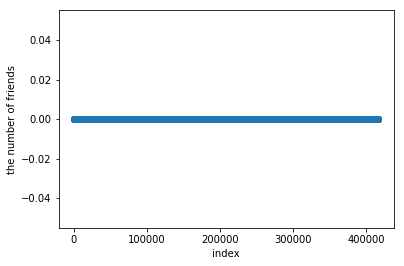

In [19]:
sorted_friend_num_list = sorted(friend_num_list, reverse=True)
x_list = np.arange(len(sorted_friend_num_list))
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel("index")
plt.ylabel("the number of friends")
plt.plot(x_list, sorted_friend_num_list, "o")
plt.show()

In [ ]:
sorted_friend_num_list

In [20]:
neigh_diff_item_num_list = []
for seq_obj in train_seq_corpus_obj.m_seq_list:
    neigh_diff_item_num = 0
    for neigh_diff_item_list in seq_obj.m_neigh_diff_item_list:
        neigh_diff_item_num += len(neigh_diff_item_list)
        
    neigh_diff_item_num_list.append(neigh_diff_item_num)

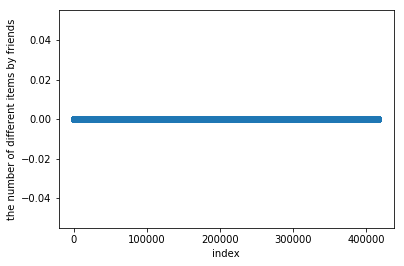

In [21]:
sorted_neigh_diff_item_num_list = sorted(neigh_diff_item_num_list, reverse=True)
x_list = np.arange(len(sorted_neigh_diff_item_num_list))
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel("index")
plt.ylabel("the number of different items by friends")
plt.plot(x_list, sorted_neigh_diff_item_num_list, "o")
plt.show()

In [347]:
sorted_neigh_diff_item_num_list[0]

5584

In [371]:
start_time = datetime.datetime.now()
end_time = datetime.datetime.now()
print(end_time-start_time)

0:00:00.000078


In [372]:
import umsgpack

In [ ]:
self.m_target = -1
self.m_item_list = []
self.m_time_list = []
self.m_target_pos = -1

self.m_neigh_diff_item_list = []
self.m_neigh_diff_time_list = []

self.m_neigh_common_item_list = [] ###[[]]
self.m_neigh_common_time_list = [] 

In [383]:
import gc
import datetime 
from multiprocessing import Pool

In [375]:
def read_seq(seq_list):
    y_list = []
    item_list = []
    time_list = []
    neigh_diff_item_list = []
    neigh_diff_time_list = []
    neigh_common_item_list = []
    neigh_common_time_list = []
    
    for seq_obj in seq_list:
        y_list.append(seq_obj.m_target)
        item_list.append(seq_obj.m_item_list)
        time_list.append(seq_obj.m_time_list)
        
        neigh_diff_item_list.append(seq_obj.m_neigh_diff_item_list)
        neigh_diff_time_list.append(seq_obj.m_neigh_diff_time_list)
        
        neigh_common_item_list.append(seq_obj.m_neigh_common_item_list)
        neigh_common_time_list.append(seq_obj.m_neigh_common_time_list)
        
    return y_list, item_list, time_list, neigh_diff_item_list, neigh_diff_time_list, neigh_common_item_list, neigh_common_time_list

In [392]:
121%4

1

In [395]:
pool_num = 4
def save_data_2_file(seq_list, file_name):
    y_file = file_name+"_target.pickle"
    x_file = file_name+"_src.pickle"
    time_file = file_name+"_time.pickle"
    
    neigh_diff_x_file = file_name+"_neigh_diff_src.pickle"
    neigh_diff_time_file = file_name+"_neigh_diff_time.pickle"
    
    neigh_common_x_file = file_name+"_neigh_common_src.pickle"
    neigh_common_time_file = file_name+"_neigh_common_time.pickle"
    
    y_list = []
    item_list = []
    time_list = []
    neigh_diff_item_list = []
    neigh_diff_time_list = []
    neigh_common_item_list = []
    neigh_common_time_list = []
    
    pool = Pool(pool_num)
    
    print("seq num", len(seq_list))
    pool_seq_list = [ [] for i in range(pool_num)]
    for seq_index, seq_obj in enumerate(seq_list):
        pool_index = seq_index%pool_num
        pool_seq_list[pool_index].append(seq_obj)
    
    results = map(read_seq, pool_seq_list)
    
    pool.close()
    pool.join()
    
    for i in range(pool_num):
        result = results[i]
        
        y_list.extend(result[0])
        item_list.extend(result[1])
        time_list.extend(result[2])
        neigh_diff_item_list.extend(result[3])
        neigh_diff_time_list.extend(result[4])
        neigh_common_item_list.extend(result[5])
        neigh_common_time_list.extend(result[6])
#     y_list = []
#     item_list = []
#     time_list = []
#     neigh_diff_item_list = []
#     neigh_diff_time_list = []
#     neigh_common_item_list = []
#     neigh_common_time_list = []
    
#     for seq_obj in seq_list:
#         y_list.append(seq_obj.m_target)
#         item_list.append(seq_obj.m_item_list)
#         time_list.append(seq_obj.m_time_list)
        
#         neigh_diff_item_list.append(seq_obj.m_neigh_diff_item_list)
#         neigh_diff_time_list.append(seq_obj.m_neigh_diff_time_list)
        
#         neigh_common_item_list.append(seq_obj.m_neigh_common_item_list)
#         neigh_common_time_list.append(seq_obj.m_neigh_common_time_list)
    
    gc.disable()
    
    f = open(y_file, "wb")
    pickle.dump(y_list, f)
    f.close()
    
    f = open(x_file, "wb")
    pickle.dump(item_list, f)
    f.close()
    
    f = open(time_file, "wb")
    pickle.dump(time_list, f)
    f.close()
    
    f = open(neigh_diff_x_file, "wb")
    pickle.dump(neigh_diff_item_list, f)
    f.close()
    
    f = open(neigh_diff_time_file, "wb")
    pickle.dump(neigh_diff_time_list, f)
    f.close()
    
    f = open(neigh_common_x_file, "wb")
    pickle.dump(neigh_common_item_list, f)
    f.close()
    
    f = open(neigh_common_time_file, "wb")
    pickle.dump(neigh_common_time_list, f)
    f.close()
    
    gc.enable()

In [398]:
start_time = datetime.datetime.now()
save_data_2_file(movielen_1m_data["train"].m_seq_list, "train")
end_time = datetime.datetime.now()
print("duration", end_time-start_time)

OSError: [Errno 12] Cannot allocate memory

In [373]:
movielens_1m_train_pickle = "../Data/ctr/movielen_1M_time_train.bin"
f = open(movielens_1m_train_pickle, "wb")
umsgpack.pack(movielen_1m_data["train"], f)
f.close()

movielens_1m_valid_pickle = "../Data/ctr/movielen_1M_time_valid.bin"
f = open(movielens_1m_valid_pickle, "wb")
umsgpack.pack(movielen_1m_data["valid"], f)
f.close()

movielens_1m_test_pickle = "../Data/ctr/movielen_1M_time_test.bin"
f = open(movielens_1m_test_pickle, "wb")
umsgpack.pack(movielen_1m_data["test"], f)
f.close()

UnsupportedTypeException: unsupported type: <class '__main__._seq_corpus'>

In [22]:
movielens_1m_train_pickle = "../Data/ctr/movielen_1M_time_train_debug.pickle"
f = open(movielens_1m_train_pickle, "wb")
pickle.dump(movielen_1m_data["train"], f)
f.close()

movielens_1m_valid_pickle = "../Data/ctr/movielen_1M_time_valid_debug.pickle"
f = open(movielens_1m_valid_pickle, "wb")
pickle.dump(movielen_1m_data["valid"], f)
f.close()

movielens_1m_test_pickle = "../Data/ctr/movielen_1M_time_test_debug.pickle"
f = open(movielens_1m_test_pickle, "wb")
pickle.dump(movielen_1m_data["test"], f)
f.close()

In [334]:
movielen_1m_pickle = "../Data/ctr/movielen_1M_time.pickle"
f = open(movielen_1m_pickle, "wb")
pickle.dump(movielen_1m_data, f)
f.close()

MemoryError: 

In [16]:
class _new_user:
    def __init__(self):
        self.m_uid = -1
        self.m_item_obj_list = collections.deque(maxlen=sequence_len_max_item)
        self.m_item_list = collections.deque(maxlen=sequence_len_max_item)
        self.m_time_list = collections.deque(maxlen=sequence_len_max_item)
        self.m_item_num = 0
        self.m_friend_id_list = collections.deque(maxlen=sequence_len_max_item) 

class _new_item:
    def __init__(self):
        self.m_iid = -1
        self.m_user_list = collections.deque(maxlen=sequence_len_max_user)
        self.m_user_num = 0

In [17]:
new_userid_obj_map = {}
new_itemid_obj_map = {}
for userid, userobj in corpus_obj.m_userid_obj_map.items():
    _new_user_obj = _new_user()
    _new_user_obj.m_uid = userobj.m_uid
    _new_user_obj.m_item_obj_list = userobj.m_item_obj_list
    _new_user_obj.m_item_list = userobj.m_item_list
    _new_user_obj.m_time_list = userobj.m_time_list
    _new_user_obj.m_item_num = userobj.m_item_num
    _new_user_obj.m_friend_id_list = userobj.m_friend_id_list
    
    new_userid_obj_map[userid] = _new_user_obj
    
for itemid, itemobj in corpus_obj.m_itemid_obj_map.items():
    _new_item_obj = _new_item()
    _new_item_obj.m_iid = itemobj.m_iid
    _new_item_obj.m_user_list = itemobj.m_user_list
    _new_item_obj.m_user_num = itemobj.m_user_num
    
    new_itemid_obj_map[itemid] = _new_item_obj
    
print("user num", len(new_userid_obj_map))
print("item num", len(new_itemid_obj_map))

user num 4478
item num 2897


In [21]:
import sys
sys.setrecursionlimit(16385)

In [22]:
movielen_1m_user_item = {}
movielen_1m_user_item["user"] = new_userid_obj_map
movielen_1m_user_item["item"] = new_itemid_obj_map

movielen_1m_user_item_pickle = "../Data/ctr/movielen_1M_time_user_item.pickle"
f = open(movielen_1m_user_item_pickle, "wb")
pickle.dump(movielen_1m_user_item, f)
f.close()

In [219]:
print(len(corpus_obj.m_userid_obj_map))
print(corpus_obj.m_user_num)

4478
4478


In [218]:
valid_seq_corpus_obj = movielen_1m_data['valid']

In [221]:
debug_seq_num = 0
for seq_obj in valid_seq_corpus_obj.m_seq_list:
    print("*"*10)
    print("target", seq_obj.m_target)
    print("item", seq_obj.m_item_list)
   
    print("neigh diff item", len(seq_obj.m_neigh_diff_item_list))
    print("negih common item", len(seq_obj.m_neigh_common_item_list))
    
    if debug_seq_num > 10:
        break
    
    debug_seq_num += 1
    

**********
target 2229
item [2383, 1606, 1487, 495, 1456, 1670, 2058, 589, 2584, 1559, 1408, 2693, 1420, 1902, 1755, 1086, 2369, 2009, 4, 2235, 352, 656, 566, 561, 873, 1454, 537, 60, 705, 284]
neigh diff item 18
negih common item 18
**********
target 492
item [478, 120, 636, 1113, 9, 1248, 597, 363, 1943, 131, 434, 790, 789, 2195, 697, 1444, 391, 693, 27, 1102, 211, 466, 397, 22, 1527, 388, 999, 1391, 620, 774]
neigh diff item 21
negih common item 21
**********
target 218
item [120, 636, 1113, 9, 1248, 597, 363, 1943, 131, 434, 790, 789, 2195, 697, 1444, 391, 693, 27, 1102, 211, 466, 397, 22, 1527, 388, 999, 1391, 620, 774, 492]
neigh diff item 16
negih common item 16
**********
target 440
item [636, 1113, 9, 1248, 597, 363, 1943, 131, 434, 790, 789, 2195, 697, 1444, 391, 693, 27, 1102, 211, 466, 397, 22, 1527, 388, 999, 1391, 620, 774, 492, 218]
neigh diff item 19
negih common item 19
**********
target 10
item [1113, 9, 1248, 597, 363, 1943, 131, 434, 790, 789, 2195, 697, 1444, 391, 

In [314]:
sorted_df = sorted_df.sort_values(by=['userid', 'timestamp'], ascending=[True, True])
print("before processing", sorted_df.shape)

before processing (494637, 3)


In [ ]:
trainTime_threshold = 975768738
validTime_threshold = 978133348

In [315]:
userid_group_list = list(sorted_df.groupby(['userid']).groups.keys())
user_num = len(userid_group_list)
print("user num", user_num)

item_list = []
time_list = []
user_list = []

item_list = sorted_df.groupby('userid')['itemid'].apply(list).values
time_list = sorted_df.groupby('userid')['timestamp'].apply(list).values

print(len(item_list), len(time_list))

len_list = [len(item_list_user) for item_list_user in item_list]
user_list = []
for len_index in range(len(item_list)):
    len_i = len_list[len_index]
    user_list_per = [len_index for i in range(len_i)]
    user_list.append(user_list_per)


user num 4478
4478 4478


In [320]:
def save_pickle_time(item, time, user):
    item_file = "../Data/movielen/ml-1m/"+"item_time.pickle"
    item_f = open(item_file, "wb")
    pickle.dump(item, item_f)
    
    time_file = "../Data/movielen/ml-1m/"+"time_time.pickle"
    time_f = open(time_file, "wb")
    pickle.dump(time, time_f)

    user_file = "../Data/movielen/ml-1m/"+"user_time.pickle"
    user_f = open(user_file, "wb")
    pickle.dump(user, user_f)

In [321]:
save_pickle_time(item_list, time_list, user_list)